🔍 BASE_DIR calculated from __file__: E:\OneDrive\Knowledge Base\0207_GenAI\Code\czsu_home2\czsu-multi-agent-text-to-sql
🔍 Current working directory: e:\OneDrive\Knowledge Base\0207_GenAI\Code\czsu_home2\czsu-multi-agent-text-to-sql
[print__memory_monitoring] ❌ Failed to load libc: Could not find module 'libc.so.6' (or one of its dependencies). Try using the full path with constructor syntax.
[print__memory_monitoring] 🧹 Memory cleanup disabled (malloc_trim not available)
rank_bm25 is available. BM25 search will be enabled.
⚠️ Using InMemorySaver fallback - consider using AsyncPostgresSaver for production
digraph {
	__start__
	rewrite_query
	retrieve_similar_selections_hybrid_search
	rerank
	relevant_selections
	retrieve_similar_chunks_hybrid_search
	rerank_chunks
	relevant_chunks
	get_schema
	query_gen
	reflect
	format_answer
	submit_final_answer
	save
	cleanup_resources
	summarize_messages_rewrite
	summarize_messages_query
	summarize_messages_reflect
	summarize_messages_format
	route_

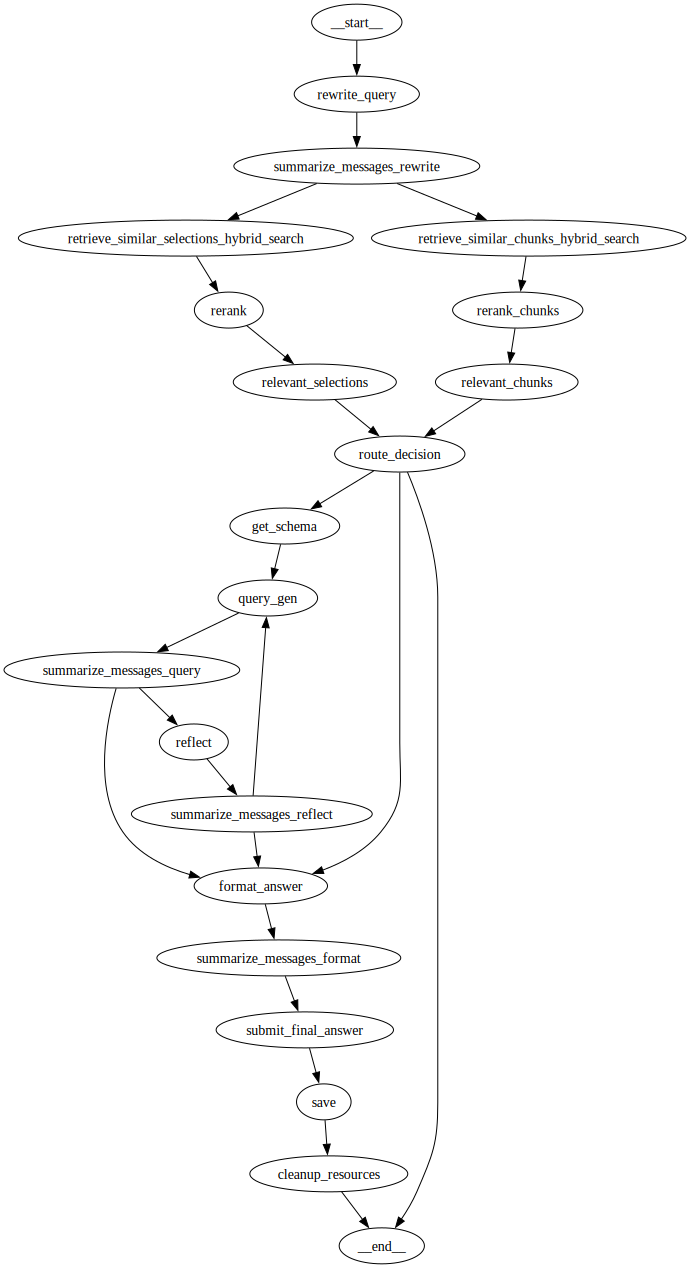

In [1]:
from IPython.display import Image, display, SVG
import graphviz
from my_agent import create_graph

# Create graph instance
app = create_graph()

# Convert to graphviz
dot = graphviz.Digraph()
for node in app.get_graph().nodes:
    dot.node(str(node))

for edge in app.get_graph().edges:
    if not (edge[0] == "query_gen" and edge[1] == "__end__"):
        if edge == ("query_gen", "format_answer"):
            dot.edge(
                str(edge[0]), str(edge[1]),
                label="max_iter",
                fontcolor="red",
                fontsize="20",
                style="bold",
                decorate="true",
                tooltip="This edge is used when max_iter is reached"
            )
        else:
            dot.edge(str(edge[0]), str(edge[1]))

# Print DOT source for debugging
print(dot.source)

# Display the graph (try SVG for best label rendering)
# display(Image(dot.pipe(format='png')))
# Or, for SVG (uncomment the next line if you want SVG output)
display(SVG(dot.pipe(format='svg')))

In [6]:
from my_agent import create_graph

def visualize_graph_text():
    # Create graph instance
    app = create_graph()
    graph = app.get_graph()
    
    # Get all nodes and edges
    nodes = list(graph.nodes)
    edges = list(graph.edges)
    
    # Print nodes
    print("Nodes:")
    for node in nodes:
        print(f"  - {node}")
    
    # Print edges
    print("\nEdges:")
    for edge in edges:
        if not (edge[0] == "query_gen" and edge[1] == "__end__"):
            print(f"  {edge[0]} -> {edge[1]}")

if __name__ == "__main__":
    visualize_graph_text()

Nodes:
  - __start__
  - retrieve_similar_selections
  - relevant_selections
  - get_schema
  - query_gen
  - reflect
  - format_answer
  - submit_final_answer
  - save
  - __end__

Edges:
  __start__ -> retrieve_similar_selections
  format_answer -> submit_final_answer
  get_schema -> query_gen
  query_gen -> format_answer
  query_gen -> reflect
  reflect -> format_answer
  reflect -> query_gen
  relevant_selections -> get_schema
  retrieve_similar_selections -> relevant_selections
  submit_final_answer -> save
  save -> __end__


20: Enter retrieve_similar_selections_node (rerank hybrid)
20: Most similar selections (rerank hybrid): [('OBY04ZEM03T01', 0.07030385), ('PRODCOM2', 0.0269635), ('PRODCOM2', 0.016529556), ('PRODCOM2', 0.011961099), ('PRODCOM2', 0.007149102), ('STAV799BT1', 0.0054905633), ('WREG0304', 0.0026730062), ('SLD051T01', 0.0022783307), ('VAV0301T02', 0.002225671), ('WZPR03T01G01', 0.0019494022)]
21: Enter relevant_selections_node
21: selection_with_possible_answer: None
Couldn't find relevant dataset selection to provide answer


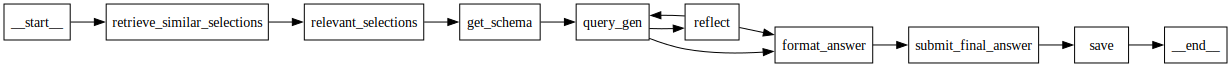


Detailed State History:


In [11]:
from IPython.display import Image, display, SVG
import graphviz
from my_agent import create_graph
import json
from typing import Dict, Any

def visualize_graph_with_state(app, state_history: Dict[str, Any] = None):
    """Visualize the graph with state information.
    
    Args:
        app: The LangGraph application instance
        state_history: Optional dictionary mapping node names to their state changes
    """
    dot = graphviz.Digraph()
    dot.attr(rankdir='LR')  # Left to right layout
    
    # Add nodes with state information
    for node in app.get_graph().nodes:
        # Create node label with state info if available
        label = str(node)
        if state_history and node in state_history:
            state_info = state_history[node]
            # Format state info as a table-like structure
            state_str = "\\n".join([f"{k}: {v}" for k, v in state_info.items()])
            label = f"{node}\\n---\\n{state_str}"
        
        dot.node(str(node), label=label, shape='box')
    
    # Add edges with conditional information
    for edge in app.get_graph().edges:
        if not (edge[0] == "query_gen" and edge[1] == "__end__"):
            if edge == ("query_gen", "format_answer"):
                dot.edge(
                    str(edge[0]), str(edge[1]),
                    label="max_iter",
                    fontcolor="red",
                    fontsize="20",
                    style="bold",
                    decorate="true",
                    tooltip="This edge is used when max_iter is reached"
                )
            else:
                dot.edge(str(edge[0]), str(edge[1]))
    
    return dot

async def track_state_changes(app, input_state: Dict[str, Any]):
    """Track state changes as the graph executes.
    
    Args:
        app: The LangGraph application instance
        input_state: Initial state to start with
    
    Returns:
        Dictionary mapping node names to their state changes
    """
    state_history = {}
    
    # Create a wrapper for each node that tracks state
    def node_wrapper(node_name):
        original_node = app.get_graph().nodes[node_name]
        
        async def wrapped_node(state):
            # Record state before node execution
            state_history[node_name] = {
                "input_state": state.copy(),
                "iteration": state.get("iteration", 0)
            }
            
            # Execute original node
            new_state = await original_node(state)
            
            # Record state after node execution
            state_history[node_name]["output_state"] = new_state.copy()
            
            return new_state
        
        return wrapped_node
    
    # Replace nodes with wrapped versions
    for node_name in app.get_graph().nodes:
        app.get_graph().nodes[node_name] = node_wrapper(node_name)
    
    # Execute the graph using ainvoke for async execution, with thread_id for checkpointing
    final_state = await app.ainvoke(input_state, config={"configurable": {"thread_id": "test-thread"}})
    
    return state_history, final_state

async def visualize_execution(prompt: str):
    # Create graph instance
    app = create_graph()
    
    # Initial state
    initial_state = {
        "prompt": prompt,
        "messages": [],
        "iteration": 0,
        "queries_and_results": [],
        "reflection_decision": None,
        "most_similar_selections": [],
        "selection_with_possible_answer": None
    }
    
    try:
        # Track state changes during execution
        state_history, final_state = await track_state_changes(app, initial_state)
        
        # Visualize graph with state information
        dot = visualize_graph_with_state(app, state_history)
        
        # Display the graph
        display(SVG(dot.pipe(format='svg')))
        
        # Optionally print detailed state history
        print("\nDetailed State History:")
        for node, history in state_history.items():
            print(f"\nNode: {node}")
            print(f"Input State: {json.dumps(history['input_state'], indent=2)}")
            print(f"Output State: {json.dumps(history['output_state'], indent=2)}")
            
    except Exception as e:
        print(f"Error during execution: {str(e)}")
        raise

import nest_asyncio
nest_asyncio.apply()  # This is needed for running async code in Jupyter

await visualize_execution("Your prompt here")